# Self-Stabilizing Gaussian Mixture Models (SGMM)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paradoxysm/dsigm/blob/master/doc/guides/SGMM_2D.ipynb)

The SGMM is a modified Gaussian Mixture Model that integrates an optimization of the ideal number of gaussian components in step with the Expectation Maximization algorithm.

The SGMM works with n-dimensional data. This is a guide on working with 2D data. For an example with 1D data, see [here](https://colab.research.google.com/github/paradoxysm/dsigm/blob/master/doc/guides/SGMM_1D.ipynb).

In [0]:
!python --version
!git clone https://github.com/paradoxysm/dsigm.git
!git -C /content/dsigm/ pull
import sys
sys.path.append('/content/dsigm')

from dsigm import SGMM, Core
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
sns.set()

Python 3.6.9
fatal: destination path 'dsigm' already exists and is not an empty directory.
Already up to date.


## A Simple 2D Example

### Creating Some Data

Let's start with creating some example 1-dimensional data to demonstrate the SGMM.

In [0]:
# define the number of samples
n = 200

# define the mean and variance of the synthetic components
mu = [[10.4, 10.2], [-1.4, 1.6], [2.4, 5.4], [6.4, 2.4]]
sigma = []
for s in range(len(mu)):
  sigma.append(make_spd_matrix(2))

# generate gaussian distributions of samples
X = []
for m, s in zip(mu,sigma):
  x = np.random.multivariate_normal(m, s, n)
  X += list(x)
X = np.array(X)
np.random.shuffle(X)
print("Dataset shape:", X.shape)

Dataset shape: (800, 2)


Let's visualize the data. To do so, let's define some helpful functions.

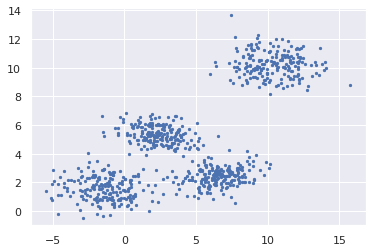

In [84]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, color=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, facecolor=color, **kwargs))

def plot(X, params=None, ax=None, color=None):
    ax = ax or plt.gca()
    labels = None
    if params is not None:
        labels = params['labels']
        mu, sigma, delta = params['mu'], params['sigma'], params['delta']
        delta_factor = 0.2 / max(delta)
        for m, s, w in zip(mu, sigma, delta):
            draw_ellipse(m, s, alpha=w * delta_factor, color=color)
    if labels is not None:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=5, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=5, zorder=2)
    ax.axis('equal')

plot(X)

### Creating Our Model

Now that we have some data, let's create our SGMM model to fit to the data.
All we need to do is make an instance. The parameters have all been included in our call here, but we're just using the default parameter values.

For more information on these parameters, read [here](https://colab.research.google.com/github/paradoxysm/dsigm/blob/master/doc/pydoc/SGMM.md).

In [0]:
sgmm = SGMM(init_cores=5, init='kmeans', stabilize=None, n_init=10, max_iter=200,
                    tol=1e-3, reg_covar=1e-6, random_state=None)

What we've just done is create an SGMM that will start with 5 "Cores." In dsigm, Cores are really just components of the distribution mixture. They are an instance of some distribution, in this implementation, a Gaussian distribution. But dsigm actually allows you to extend the Core to implement different distributions. For more information, read about Cores here.

In addition, our stabilize rate modifier is set at 0.05. You can set it `None` if you are looking for a GMM that doesn't stabilize!

### Fitting Our Model

To fit our model to the data, we only need to make a single call.

In [131]:
sgmm.fit(X)

### Visualizing the Result

Let's examine how well the model has fit the data.

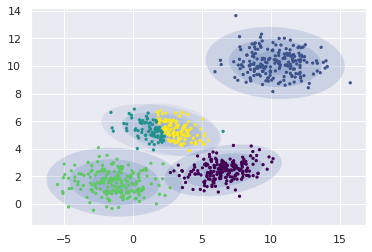

In [132]:
# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)
params['labels'] = sgmm.predict(X)

# plot the results
plot(X, params=params)

You can see how the model has adjusted to the optimal number of components and fits the distribution mixture nicely!

### Predicting New Data

Working with assumption that the data we just provided our model generally represents the real world, we can feed our model new data and determine which of the components it is likely to belong to. This is simply done by finding under which Core (or Gaussian component) the new sample has the highest probability.

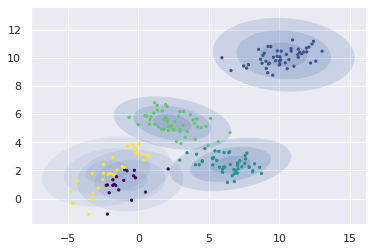

In [87]:
# define the number of samples
n = 50

# generate some data that fit the distribution
Y = []
for m, s in zip(mu,sigma):
  y = np.random.multivariate_normal(m, s, n)
  Y += list(y)
Y = np.array(Y)
np.random.shuffle(Y)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)
params['labels'] = sgmm.predict(Y)

# plot the results
plot(Y, params=params)

And some slightly modified data...

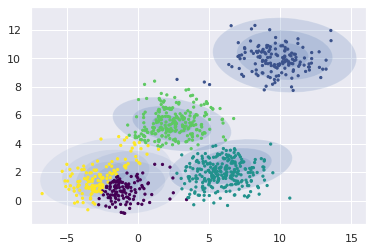

In [88]:
# define the number of samples
n = 30

# generate some data that deviate partially from the distribution
Y_off = []
for i in range(n):
    Z = np.random.choice(np.arange(len(mu))) # select the synthetic component
    mu_modify = np.random.choice([-1,1]) * np.random.random() + mu[Z]
    sigma_modify = make_spd_matrix(2)
    y = np.random.multivariate_normal(mu_modify, sigma_modify, n)
    Y_off += list(y)
Y_off = np.array(Y_off)
np.random.shuffle(Y_off)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)
params['labels'] = sgmm.predict(Y_off)

# plot the results
plot(Y_off, params=params)

## A More Complicated 2D Example

Sometimes the data may be not so nicely grouped or they may be highly eccentric. However, since Gaussian Mixtures utilize the Gaussian distribution with full covariances, we can still model such data quite accurately.


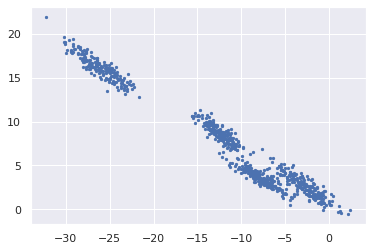

In [142]:
# mutate the data
X_stretched = np.dot(X, np.random.RandomState(2).randn(2, 2))

plot(X_stretched)

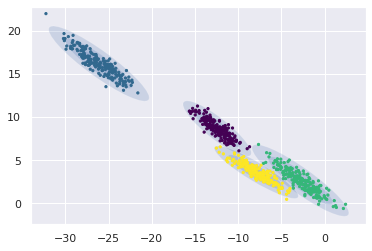

In [143]:
sgmm = SGMM(init_cores=4, stabilize=None)
sgmm.fit(X_stretched)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)
params['labels'] = sgmm.predict(X_stretched)

# plot the results
plot(X_stretched, params=params)

## Irregularly Shaped Data

Gaussian Mixture Models are, technically speaking, a generative probabilistic model to describe the distribution of the data.

When used as a clustering algorithm, these mixture models are restricted by the ellipsoidal nature of Gaussian distributions. This can be seen in the following example.


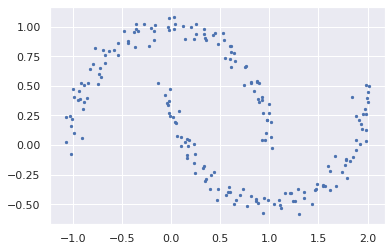

In [101]:
from sklearn.datasets import make_moons

# create some irregular data
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], s=5)

With a simple Gaussian Mixture Model used as a clustering algorithm, we don't get very usable results.

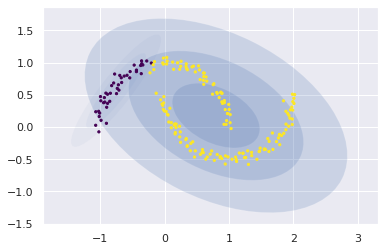

In [125]:
sgmm = SGMM(init_cores=2, stabilize=None)
sgmm.fit(Xmoon)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)
params['labels'] = sgmm.predict(Xmoon)

# plot the results
plot(Xmoon, params=params)

But when we remove the distinction between each component and simply use them to model the distribution, we can model irregular distributions.

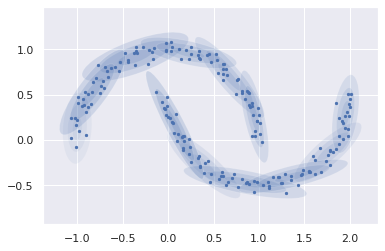

In [138]:
sgmm = SGMM(init_cores=12, stabilize=None)
sgmm.fit(Xmoon)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)

# plot the results
plot(Xmoon, params=params)

## A Non-Stabilizing Model

SGMM also allows for non-stabilizing models, essentially becoming a normal Gaussian Mixture Model.

Let's create one such model with 3 Cores and fit it to our original training data.

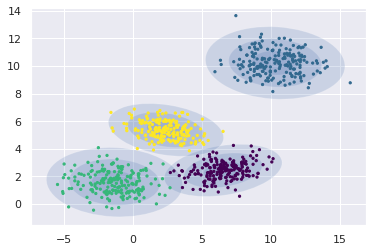

In [0]:
sgmm_fixed = SGMM(init_cores=4, stabilize=None)
sgmm_fixed.fit(X)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm_fixed.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)
params['labels'] = sgmm_fixed.predict(X)

# plot the results
plot(X, params=params)

We can compare our model with a GaussianMixture from sklearn.

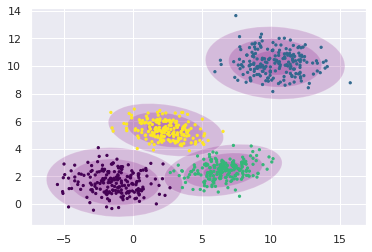

In [96]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
gmm.fit(X)

# gmm model
# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
params['mu'] = gmm.means_
params['sigma'] = gmm.covariances_
params['delta'] = gmm.weights_
params['labels'] = gmm.predict(X)

# plot the results
plot(X, params=params, color='purple')

You'll notice they converge to an exactly equivalent model!